In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.model_selection import train_test_split
import math
from scipy.stats import wasserstein_distance

In [2]:
print(f'CUDA available: {torch.cuda.is_available()}')
print(f'CUDA current: {torch.cuda.current_device()}')

CUDA available: True
CUDA current: 0


In [3]:
class dataGenerator():
    def __init__(self, batchsize, bins):
        self.batchsize=batchsize
        self.bins=bins
    
    def datagen(self):
        histograms = np.zeros((self.batchsize, 30), dtype=np.int64)
        means = np.zeros(self.batchsize)
        sigmas = np.zeros(self.batchsize)
        total_counts = np.zeros(self.batchsize)
        for i in range(self.batchsize):
            nsamples = np.random.randint(0,10000)
            mu = np.random.uniform(0.2,0.4)
            sigma = np.random.uniform(0.1, 0.3)

            samples = np.random.normal(mu, sigma, nsamples)

            hist,counts = np.histogram(samples, bins=self.bins, range=(0,1))
            histograms[i,:] = hist
            means[i] = mu
            sigmas[i] = sigma
            total_counts[i] = hist.sum()

        return histograms, means, sigmas, total_counts

In [4]:
data = dataGenerator(1000000,30)

In [5]:
%time
hist, means, sigmas, counts = data.datagen()

CPU times: user 2 μs, sys: 0 ns, total: 2 μs
Wall time: 5.48 μs


In [6]:
means = np.array(means)
sigmas = np.array(sigmas)
counts = np.array(counts)
conds = np.column_stack([means, sigmas, counts])

In [7]:
hist_train, hist_test, conds_train, conds_test = train_test_split(hist,conds, test_size=0.2, random_state=42)

hist_test = torch.tensor(hist_test, dtype=torch.float32)
hist_test = hist_test/hist_test.max().item()
hist_train = torch.tensor(hist_train, dtype=torch.float32)
hist_train = hist_train/hist_train.max().item()
conds_test = torch.tensor(conds_test, dtype=torch.float32)
conds_train = torch.tensor(conds_train, dtype=torch.float32)


In [8]:
indicies = torch.randint(0, len(hist_test), (32,))
test_histograms = hist_test[indicies]
conditionx = conds_train[indicies]

In [9]:
train_dataset = torch.utils.data.TensorDataset(hist_train, conds_train)
train_loader = torch.utils.data.DataLoader(
            train_dataset,
            batch_size = 128, 
            shuffle=True
        )

In [10]:
class Generator(torch.nn.Module):
    def __init__(self, input_dim, bins, hidden_dim):
        super().__init__()
        self.Model = torch.nn.Sequential(
            torch.nn.Linear(input_dim, hidden_dim),
            torch.nn.BatchNorm1d(hidden_dim),
            torch.nn.LeakyReLU(0.2),
            
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.BatchNorm1d(hidden_dim),
            torch.nn.LeakyReLU(0.2),

            torch.nn.Linear(hidden_dim, hidden_dim * 4),
            torch.nn.BatchNorm1d(hidden_dim * 4),
            torch.nn.LeakyReLU(0.2),
            
            torch.nn.Linear(hidden_dim *4, hidden_dim * 4),
            torch.nn.BatchNorm1d(hidden_dim * 4),
            torch.nn.LeakyReLU(0.2),
            
            torch.nn.Linear(hidden_dim * 4, hidden_dim * 8),
            torch.nn.BatchNorm1d(hidden_dim * 8),
            torch.nn.LeakyReLU(0.2),
            
            torch.nn.Linear(hidden_dim * 8, hidden_dim * 8),
            torch.nn.BatchNorm1d(hidden_dim * 8),
            torch.nn.LeakyReLU(0.2),

            torch.nn.Linear(hidden_dim * 8, bins),
            torch.nn.Softplus()

        )

    def forward(self, x):
        return self.Model(x)       

In [11]:
class Discriminator(torch.nn.Module):
    def __init__(self, bins, input_dim, hidden_dim):
        super().__init__()
        self.Model = torch.nn.Sequential(
            torch.nn.Linear(input_dim+bins, hidden_dim),
            torch.nn.LeakyReLU(0.2),
            torch.nn.Dropout(0.3),

            torch.nn.Linear(hidden_dim, hidden_dim * 2),
            torch.nn.LeakyReLU(0.2),
            torch.nn.Dropout(0.3),

            torch.nn.Linear(hidden_dim * 2, hidden_dim * 4),
            torch.nn.LeakyReLU(0.2),
            torch.nn.Dropout(0.3),

            torch.nn.Linear(hidden_dim * 4, hidden_dim * 2),
            torch.nn.LeakyReLU(0.2),
            torch.nn.Dropout(0.3),

            torch.nn.Linear(hidden_dim * 2, hidden_dim // 2),
            torch.nn.LeakyReLU(0.2),
            torch.nn.Dropout(0.3),

            torch.nn.Linear(hidden_dim // 2, 1),
            torch.nn.Sigmoid()
        )
    
    def forward(self, hist,cond):
        x = torch.cat([hist,cond], dim=1)
        return self.Model(x)


In [24]:
class HistGenerator:
    def __init__(self, x_test, x_train, t_test, t_train, input_dim, bins = 30, hidden_dim = 64, lambda_recon = 10.0):
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.x_test=x_test
        self.x_train=x_train
        self.t_test=t_test
        self.t_train=t_train
        self.bins=bins
        self.lambda_recon = lambda_recon

        self.batch_size = 16
        self.generator = Generator(input_dim, bins, hidden_dim)
        self.discriminator = Discriminator(bins, input_dim,hidden_dim)

        self.gen_optim = torch.optim.Adam(self.generator.parameters(), lr=0.0001, betas=(0.5, 0.999))
        self.discri_optim = torch.optim.Adam(self.discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

        self.criterion = torch.nn.BCELoss()

        self.d_losses = []
        self.g_losses = []
        self.recon_losses = []

        self.d_losses_test = []
        self.g_losses_test = []

        train_dataset = torch.utils.data.TensorDataset(self.x_train, self.t_train)
        test_dataset = torch.utils.data.TensorDataset(self.x_test, self.t_test)

        self.train_loader = torch.utils.data.DataLoader(
            train_dataset,
            batch_size = self.batch_size, 
            shuffle=True
        )

        self.test_loader = torch.utils.data.DataLoader(
            test_dataset,
            batch_size = self.batch_size, 
            shuffle=True
        )

    def training(self, batch_size, x_train, t_train):
        ##Trainng the discriminator ##
        self.discriminator.zero_grad()       

        ##data

        real_hist = x_train 
        conditions = t_train    
        real_labels = torch.ones(batch_size, 1)

        real_output = self.discriminator(real_hist, conditions)
        real_loss_dis = self.criterion(real_output, real_labels)

        ##Fake histograms
        fake_hist = self.generator(conditions)
        fake_labels = torch.zeros(batch_size, 1)

        fake_output = self.discriminator(fake_hist.detach(), conditions)
        fake_loss_dis = self.criterion(fake_output, fake_labels)

        disc_loss = real_loss_dis + fake_loss_dis  ## Adversarial loss ##
        disc_loss.backward()
        self.discri_optim.step()

        ## Training Generator ##

        self.generator.zero_grad()

        fake_hist = self.generator(conditions)
        
        ## Fooling the discriminator ## 

        output = self.discriminator(fake_hist, conditions)
        g_loss = self.criterion(output,real_labels)   ## Adversarial loss ## 
        reconstruction_loss = torch.nn.PoissonNLLLoss(log_input=False)(fake_hist, real_hist)
        g_loss_total = g_loss + 10 * reconstruction_loss

        g_loss_total.backward()
        self.gen_optim.step()

        return disc_loss.item(), g_loss.item(), reconstruction_loss.item()
    
    def evaluate(self, n_samples=100, batch_size=16):
        self.generator.eval()
        self.discriminator.eval()

        with torch.no_grad():
            indicies = torch.randint(0, len(self.x_test), (batch_size,))
            conditions = self.t_test[indicies]
            fake_histograms = self.generator(conditions)
            test_histograms = self.x_test[indicies]

            real_labels = torch.ones(batch_size, 1)
            fake_labels = torch.zeros(batch_size, 1)
            

            EMD = np.zeros(batch_size)
            for i in range(batch_size):
                EMD[i] = wasserstein_distance(fake_histograms[i].detach().numpy(), test_histograms[i].detach().numpy())

            wasserstein_score = EMD.mean()

            test_scores = self.discriminator(test_histograms, conditions)
            gen_scores = self.discriminator(fake_histograms, conditions)

            d_loss_real = self.criterion(test_scores, real_labels)
            d_loss_fake = self.criterion(gen_scores, fake_labels)
            d_loss_test = d_loss_real+d_loss_real

            self.d_losses_test.append(d_loss_test)

            output = self.discriminator(fake_histograms, conditions)
            g_loss_test = self.criterion(output, real_labels)

            self.g_losses_test.append(g_loss_test)

        self.generator.train()
        self.discriminator.train()

        metrics = {
            'test_mean_count': test_histograms.mean(),
            'gen_mean_count': fake_histograms.mean(),
            'test_std': test_histograms.std(),
            'gen_std': fake_histograms.std(),
            'test_disc_score': test_scores.mean(),
            'gen_disc_score': gen_scores.mean(),
            'wasserstein_dist': wasserstein_score,
            'Test loss generator': g_loss_test.item(),
            'Test loss discriminator': d_loss_test.item()
        }
        
        return metrics
            

    
    def train(self, epochs, batch_size = 16, print_every = 200, eval_every=500):

        print(f"Training the network for {epochs} epochs")
        num_batches_to_run = 5000
        for epoch in range(epochs):
            for i,(real_data, conditions) in enumerate(self.train_loader): 
                if i>num_batches_to_run:
                    break
                disc_loss, g_loss, reconstruction_loss = self.training(batch_size, real_data, conditions)
                self.d_losses.append(disc_loss)
                self.g_losses.append(g_loss)
                self.recon_losses.append(reconstruction_loss)
                if (epoch + 1) % print_every == 0:
                    print(f"Epoch [{epoch + 1}/{epoch}] | Discriminator Loss: {disc_loss:.4f} | Generator Loss: {g_loss:.4f} | Reconstruction Loss: {reconstruction_loss:.4f}")
                if (epoch+1) % eval_every == 0:
                    metrics = self.evaluate()
                    print(f"\n--- Test Set Evaluation (Epoch {epoch+1}) ---")
                    print(f"  Test mean count: {metrics['test_mean_count']:.2f}")
                    print(f"  Gen mean count:  {metrics['gen_mean_count']:.2f}")
                    print(f"  Discriminator score on test: {metrics['test_disc_score']:.3f}")
                    print(f"  Discriminator score on gen:  {metrics['gen_disc_score']:.3f}")
                    print(f"  Generator loss on test data: {metrics['Test loss generator']:.3f}")
                    print(f"  Discriminator loss on test data: {metrics['Test loss discriminator']:.3f}")
                    print(f"  Wasserstein Distance for the generated samples is: {metrics['wasserstein_dist']:.3f}")
                    print("-" * 60 + "\n")


    def generate_histograms(self, input_vectors):
        """Generate histograms from input vectors"""
        self.generator.eval()
        with torch.no_grad():
            if isinstance(input_vectors, np.ndarray):
                input_vectors = torch.FloatTensor(input_vectors)
            histograms = self.generator(input_vectors)
        self.generator.train()
        return histograms.numpy()
        
    def plot_results(self, n = 4):
        indicies = torch.randint(0, len(self.x_test), (n,))
        
        conditions = self.t_test[indicies]
        fake_hist = self.generate_histograms(conditions)

        test_histograms = self.x_test[indicies]
        grid_size = int(math.sqrt(n))
        fig, axes = plt.subplots(grid_size, grid_size, figsize = (15,6))
        for i in range(n):
            row = i // grid_size
            col = i % grid_size
            ## Here real histograms are to be plotted ##
            axes[row, col].plot(range(self.bins), test_histograms[i], color = 'blue', alpha=0.7, label='Data')
            axes[row, col].plot(range(self.bins), fake_hist[i], color='red', alpha=0.7, label='Generated')
            axes[row, col].set_ylabel('Counts')
    
        plt.tight_layout()
        plt.legend()
        plt.show() 

    def plot_loss(self):
        plt.figure(figsize=(10, 5))
        plt.plot(self.d_losses, label='Discriminator Loss', alpha=0.7)
        plt.plot(self.g_losses, label='Generator Loss', alpha=0.7)
        plt.xlabel('Training Steps')
        plt.ylabel('Loss')
        plt.title('GAN Training/Test Losses')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()  

        plt.figure(figsize=(10, 5))
        plt.plot(self.d_losses_test, label='Discriminator Loss Test', alpha=0.7)
        plt.plot(self.g_losses_test, label='Generator Loss Test', alpha=0.7)
        plt.xlabel('Training Steps')
        plt.ylabel('Loss')
        plt.title('GAN Training/Test Losses')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()  

In [ ]:
gan = HistGenerator(x_test=hist_test,
                    x_train=hist_train,
                    t_test=conds_test,
                    t_train=conds_train,
                    input_dim=3, 
                    bins=30, 
                    hidden_dim=256,
                    )

gan.train(epochs=100, 
          batch_size=16, 
          print_every=10, 
          eval_every=10
          )

gan.plot_loss()

Training the network for 100 epochs
Epoch [10/9] | Discriminator Loss: 1.3890 | Generator Loss: 0.7032 | Reconstruction Loss: 0.2827

--- Test Set Evaluation (Epoch 10) ---
  Test mean count: 0.08
  Gen mean count:  0.09
  Discriminator score on test: 0.496
  Discriminator score on gen:  0.496
  Generator loss on test data: 0.702
  Discriminator loss on test data: 1.404
  Wasserstein Distance for the generated samples is: 0.025
------------------------------------------------------------

Epoch [10/9] | Discriminator Loss: 1.3918 | Generator Loss: 0.7020 | Reconstruction Loss: 0.2887

--- Test Set Evaluation (Epoch 10) ---
  Test mean count: 0.12
  Gen mean count:  0.12
  Discriminator score on test: 0.493
  Discriminator score on gen:  0.491
  Generator loss on test data: 0.710
  Discriminator loss on test data: 1.416
  Wasserstein Distance for the generated samples is: 0.015
------------------------------------------------------------

Epoch [10/9] | Discriminator Loss: 1.3825 | Gene

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch [20/19] | Discriminator Loss: 1.3899 | Generator Loss: 0.7258 | Reconstruction Loss: 0.2773

--- Test Set Evaluation (Epoch 20) ---
  Test mean count: 0.12
  Gen mean count:  0.10
  Discriminator score on test: 0.487
  Discriminator score on gen:  0.487
  Generator loss on test data: 0.721
  Discriminator loss on test data: 1.437
  Wasserstein Distance for the generated samples is: 0.029
------------------------------------------------------------

Epoch [20/19] | Discriminator Loss: 1.3816 | Generator Loss: 0.7227 | Reconstruction Loss: 0.2951

--- Test Set Evaluation (Epoch 20) ---
  Test mean count: 0.08
  Gen mean count:  0.07
  Discriminator score on test: 0.494
  Discriminator score on gen:  0.493
  Generator loss on test data: 0.706
  Discriminator loss on test data: 1.412
  Wasserstein Distance for the generated samples is: 0.014
------------------------------------------------------------

Epoch [20/19] | Discriminator Loss: 1.3780 | Generator Loss: 0.7040 | Reconstructi

In [ ]:
gan.plot_results(n=25)

In [15]:
histA = gan.generate_histograms(torch.tensor([[0.2,1.0,800], [0.4,1,800]]))

In [16]:
print(histA[0].sum())
print(histA[1].sum())

1.3663045
1.4600486


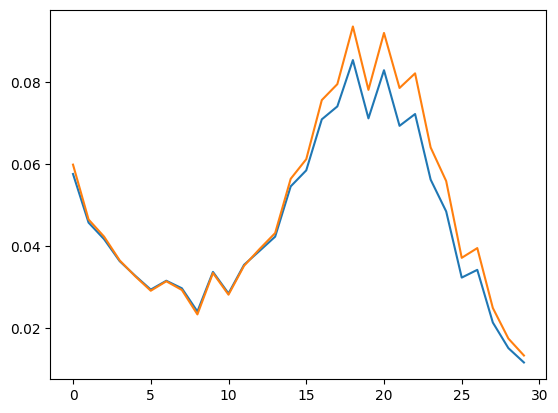

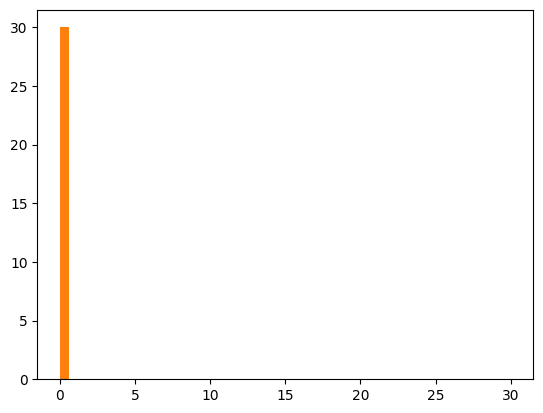

In [17]:
plt.plot(range(30), histA[0])
plt.plot(range(30), histA[1])
plt.show()

plt.hist(histA[0], bins=np.linspace(0,30))
plt.hist(histA[1], bins=np.linspace(0,30))
plt.show()

In [273]:

plt.show()